## Imports

In [6]:
import pandas as pd
import json
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
from sklearn.decomposition import PCA                                     

## Data loading

In [10]:
# Path to the documents directory                                         
documents_path = './data/'                            
                                                                            
# Initialize an empty DataFrame for word frequencies                      
word_freq_df = pd.DataFrame(columns=['word', 'frequency'])                
                                                                            
# Process the word frequency CSV files                                    
for csv_file in glob.glob(os.path.join(documents_path, '*/words_freq.csv')):                                                       
    df = pd.read_csv(csv_file)                                            
    word_freq_df = pd.concat([word_freq_df, df], ignore_index=True)       
                                                                            
# Process the entities frequency JSON files                               
entity_freq_records = []                                                  
for json_file in glob.glob(os.path.join(documents_path, '*/entities_freq.json')):                                                   
    with open(json_file, 'r') as f:                                       
        entities_freq = json.load(f)                                      
        for word, frequency in entities_freq.items():                     
            entity_freq_records.append({'word': word, 'frequency': frequency})                                                                 
                                                                            
entity_freq_df = pd.DataFrame(entity_freq_records)  

# Combine the two DataFrames                                              
combined_freq_df = pd.concat([word_freq_df, entity_freq_df], ignore_index=True)                                                          

# Aggregate the frequencies by word                                       
aggregated_freq_df = combined_freq_df.groupby('word', as_index=False).sum()                                                       

In [11]:
# Compute summary statistics                                              
summary_statistics = {                                                    
    'total_words': aggregated_freq_df['word'].nunique(),                  
    'mean_frequency': aggregated_freq_df['frequency'].mean(),             
    'median_frequency': aggregated_freq_df['frequency'].median(),         
    'std_dev_frequency': aggregated_freq_df['frequency'].std(),           
    'min_frequency': aggregated_freq_df['frequency'].min(),               
    'max_frequency': aggregated_freq_df['frequency'].max(),               
}                                                                         
                                                                            
# Print summary statistics                                                
print("Summary Statistics of the Number of Words:")                       
for stat, value in summary_statistics.items():                            
    print(f"{stat}: {value}")                                             
                                                                            
# Optionally, convert summary statistics to a DataFrame for better        visualization                                                               
summary_df = pd.DataFrame([summary_statistics])                           
print(summary_df)

Summary Statistics of the Number of Words:
total_words: 7356
mean_frequency: 6.9090538336052205
median_frequency: 1.0
std_dev_frequency: 64.72674577715695
min_frequency: 1
max_frequency: 3962
   total_words  mean_frequency  median_frequency  std_dev_frequency  \
0         7356        6.909054               1.0          64.726746   

   min_frequency  max_frequency  
0              1           3962  


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vlermanda/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


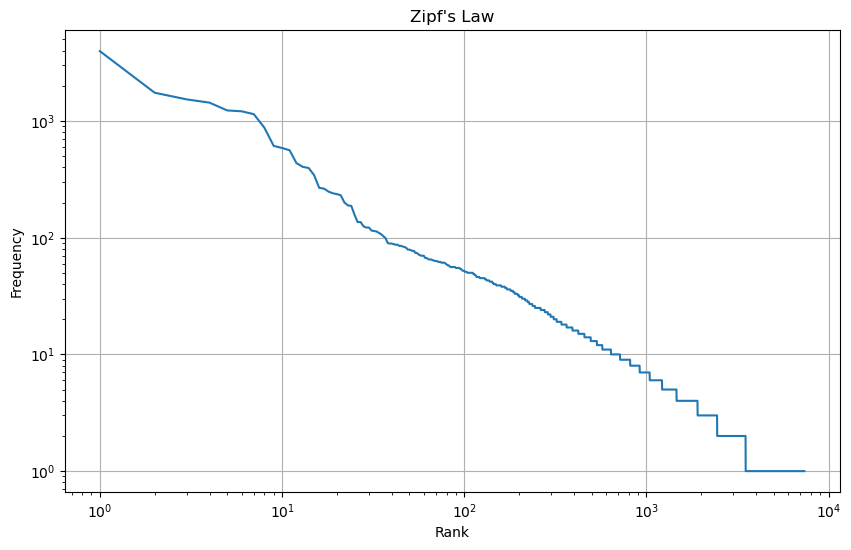

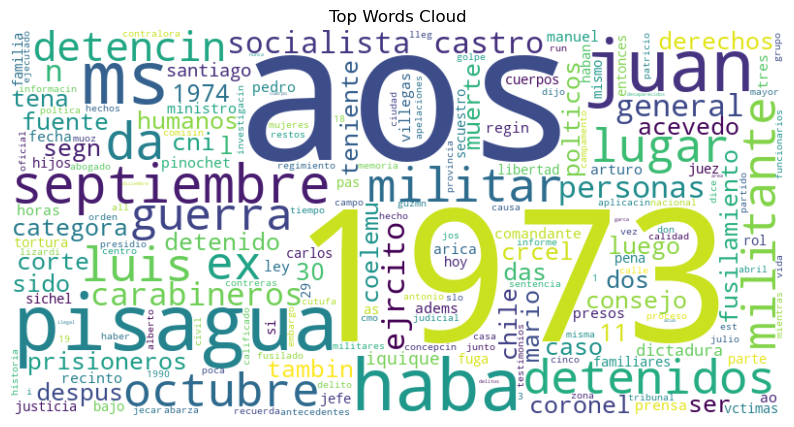

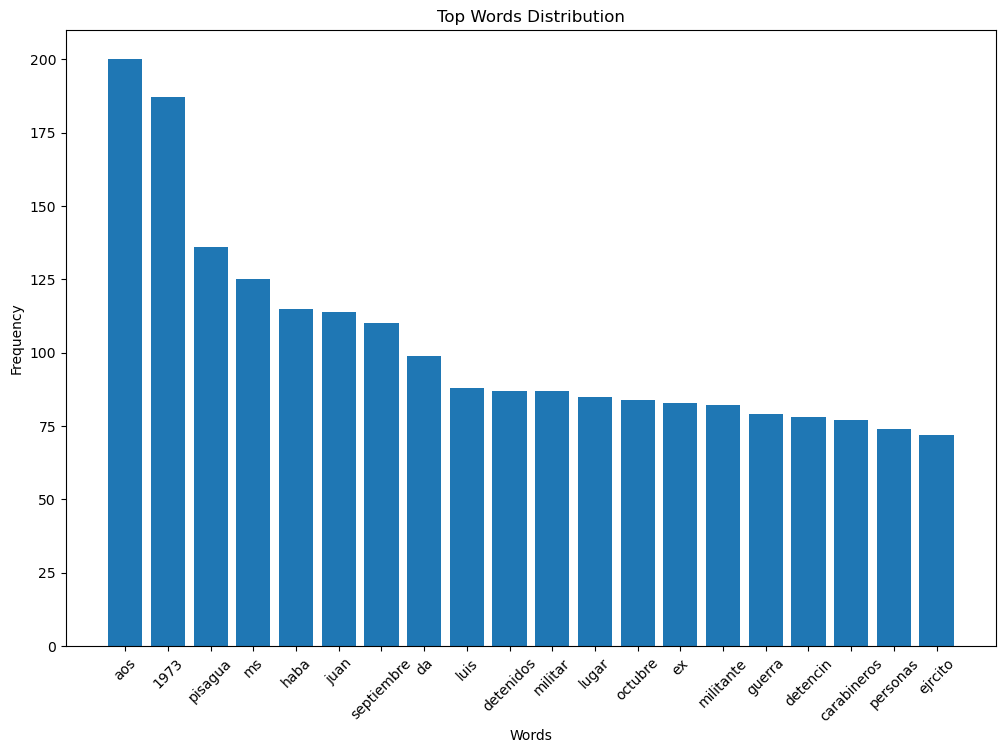

In [13]:
# Ensure you have the stopwords                                           
nltk.download('stopwords')                                                
                                                                        
# Step 2.1: Zipf's Law                                                    
aggregated_freq_df = aggregated_freq_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)                                     
aggregated_freq_df['rank'] = aggregated_freq_df.index + 1                 
                                                                        
plt.figure(figsize=(10, 6))                                               
plt.loglog(aggregated_freq_df['rank'], aggregated_freq_df['frequency'])   
plt.xlabel('Rank')                                                        
plt.ylabel('Frequency')                                                   
plt.title("Zipf's Law")                                                   
plt.grid(True)                                                            
plt.show()                                                                
                                                                        
# Step 2.2: Removing Spanish Stop Words                                   
spanish_stop_words = set(stopwords.words('spanish'))                      
filtered_freq_df = aggregated_freq_df[~aggregated_freq_df['word'].isin(spanish_stop_words)]    
                                                                        
# Step 2.3: Top Words Visualization                                       
# Word Cloud                                                              
wordcloud = WordCloud(width=800, height=400,                              
background_color='white').generate_from_frequencies(                        
    dict(zip(filtered_freq_df['word'], filtered_freq_df['frequency']))    
)                                                                         
                                                                        
plt.figure(figsize=(10, 6))                                               
plt.imshow(wordcloud, interpolation='bilinear')                           
plt.axis('off')                                                           
plt.title('Top Words Cloud')                                              
plt.show()                                                                
                                                                        
# Distribution of Top Words                                               
top_words_df = filtered_freq_df.head(20)  # Adjust the number of top words as needed                                                                   
                                                                        
plt.figure(figsize=(12, 8))                                               
plt.bar(top_words_df['word'], top_words_df['frequency'])                  
plt.xlabel('Words')                                                       
plt.ylabel('Frequency')                                                   
plt.title('Top Words Distribution')                                       
plt.xticks(rotation=45)                                                   
plt.show()  

In [14]:
# Step 3.1: Top Entities (Aggregated Data)                                
aggregated_entity_freq_df = entity_freq_df.groupby('word', as_index=False).sum()                                                       
top_entities_df = aggregated_entity_freq_df.sort_values(by='frequency', ascending=False).head(20)
                                                                            
plt.figure(figsize=(12, 8))                                               
plt.bar(top_entities_df['word'], top_entities_df['frequency'])            
plt.xlabel('Entities')                                                    
plt.ylabel('Frequency')                                                   
plt.title('Top Entities')                                                 
plt.xticks(rotation=45)                                                   
plt.show()                                                                
                                                                            
# Step 3.2: Entity Co-occurrence Heatmap (Non-aggregated Data)            
# Initialize a dictionary to keep track of co-occurrences                 
co_occurrence_dict = defaultdict(lambda: defaultdict(int))                
                                                                            
# Process each document's entities                                        
for json_file in glob.glob(os.path.join(documents_path, '*/entities_freq.json')):                                                   
    with open(json_file, 'r') as f:                                       
        entities_freq = json.load(f)                                      
        entities = list(entities_freq.keys())                             
        for entity1, entity2 in combinations(entities, 2):                
            co_occurrence_dict[entity1][entity2] += 1                     
            co_occurrence_dict[entity2][entity1] += 1                     
                                                                            
# Convert co-occurrence dictionary to DataFrame                           
co_occurrence_df = pd.DataFrame(co_occurrence_dict).fillna(0)             
                                                                            
# Select top entities for the heatmap                                     
top_entities = top_entities_df['word'].tolist()                           
co_occurrence_df = co_occurrence_df.loc[top_entities, top_entities]       
                                                                            
# Plot heatmap                                                            
plt.figure(figsize=(12, 10))                                              
sns.heatmap(co_occurrence_df, annot=True, cmap='Blues', fmt='g')          
plt.title('Entity Co-occurrence Heatmap')                                 
plt.show()

KeyError: 'word'

In [ ]:
# Function to get word embedding from Elasticsearch                       
def get_word_embedding(word):                                             
    # This is a placeholder function. Replace it with actual code to fetch the embedding from Elasticsearch.                                           
    # For example:                                                        
    # response = elasticsearch_client.get(index='your_index', id=word)    
    # embedding = response['_source']['embedding']                        
    # return np.array(embedding)                                          
    pass                                                                  
                                                                          
# Step 4.1: Dimensionality Reduction Scatterplot of Top Words             
top_words_df = aggregated_freq_df.sort_values(by='frequency', ascending=False).head(100)
top_words = top_words_df['word'].tolist()                                 
                                                                          
# Get embeddings for top words                                            
top_word_embeddings = np.array([get_word_embedding(word) for word in top_words])                                                                 
                                                                          
# Perform PCA                                                             
pca = PCA(n_components=2)                                                 
top_words_pca = pca.fit_transform(top_word_embeddings)                    
                                                                          
# Plot PCA results                                                        
plt.figure(figsize=(12, 8))                                               
plt.scatter(top_words_pca[:, 0], top_words_pca[:, 1])                     
                                                                          
for i, word in enumerate(top_words):                                      
    plt.annotate(word, (top_words_pca[i, 0], top_words_pca[i, 1]))        
                                                                          
plt.title('PCA of Top Words')                                             
plt.xlabel('PCA Component 1')                                             
plt.ylabel('PCA Component 2')                                             
plt.grid(True)                                                            
plt.show()                                                                
                                                                          
# Step 4.2: Dimensionality Reduction Scatterplot of Entities Words        
top_entities_df = entity_freq_df.groupby('word', as_index=False).sum().sort_values(by='frequency', ascending=False).head(100)
# Adjust the number of top entities as needed                               
top_entities = top_entities_df['word'].tolist()                           
                                                                          
# Get embeddings for top entities                                         
top_entity_embeddings = np.array([get_word_embedding(word) for word in top_entities])                                                              
                                                                          
# Perform PCA                                                             
top_entities_pca = pca.fit_transform(top_entity_embeddings)               
                                                                          
# Plot PCA results                                                        
plt.figure(figsize=(12, 8))                                               
plt.scatter(top_entities_pca[:, 0], top_entities_pca[:, 1])               
                                                                          
for i, word in enumerate(top_entities):                                   
    plt.annotate(word, (top_entities_pca[i, 0], top_entities_pca[i, 1]))  
                                                                          
plt.title('PCA of Entities Words')                                        
plt.xlabel('PCA Component 1')                                             
plt.ylabel('PCA Component 2')                                             
plt.grid(True)                                                            
plt.show()